Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=678, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=678, bias=True)
    (5): Sigmoid()
  )
)
Epoch [1/100], Loss: 1.8757
Epoch [2/100], Loss: 1.5554
Epoch [3/100], Loss: 0.9046
Epoch [4/100], Loss: 0.8028
Epoch [5/100], Loss: 0.7763
Epoch [6/100], Loss: 0.7792
Epoch [7/100], Loss: 0.9973
Epoch [8/100], Loss: 0.8214
Epoch [9/100], Loss: 3.4584
Epoch [10/100], Loss: 0.6712
Epoch [11/100], Loss: 0.8140
Epoch [12/100], Loss: 1.1237
Epoch [13/100], Loss: 0.7638
Epoch [14/100], Loss: 0.5930
Epoch [15/100], Loss: 1.7777
Epoch [1

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

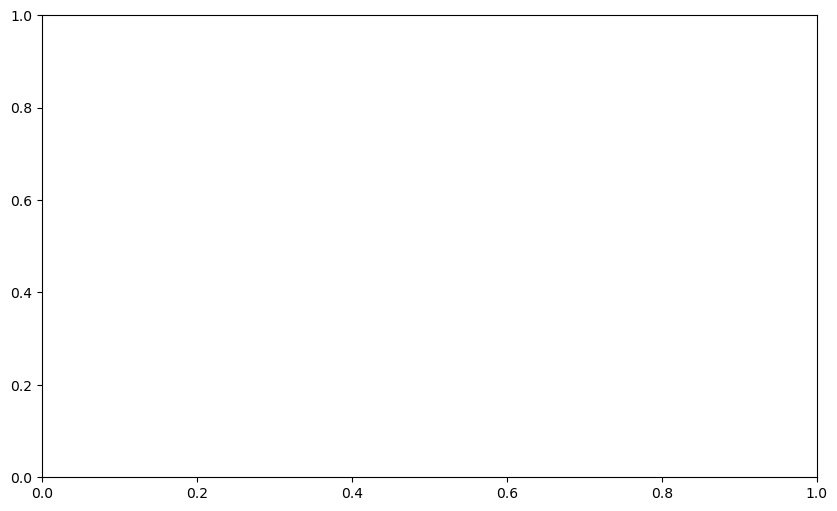

In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
recipes = pd.read_csv('/Users/giovannimaya/Downloads/epi_r-1 (1).csv')

# Define the target and features
target = recipes['cake']
feats = recipes.drop(columns=['cake'])

# Select numeric columns and fill missing values with medians
numeric_cols = feats.select_dtypes(include=['number']).columns
means = feats[numeric_cols].mean()
feats[numeric_cols] = feats[numeric_cols].fillna(means)

# Standardize numeric columns
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(feats[numeric_cols])

# Convert DataFrame to torch tensor
tensor_data = torch.tensor(numeric_data_scaled, dtype=torch.float32)
target_data = torch.tensor(target.values, dtype=torch.float32).reshape(-1, 1)

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, encoding_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = tensor_data.shape[1]
encoding_dim = 10  # Reduced dimension

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=10)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.AdamW(autoencoder.parameters(), lr=0.001) 


print(autoencoder)

num_epochs = 100 
batch_size = 32  


train_loader = torch.utils.data.DataLoader(tensor_data, batch_size=batch_size, shuffle=True)

losses = []

start_time = time.time()

for epoch in range(num_epochs):
    for data in train_loader:
        reconstructed = autoencoder(data)
        loss = criterion(reconstructed, data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time / 60:.2f} minutes.")



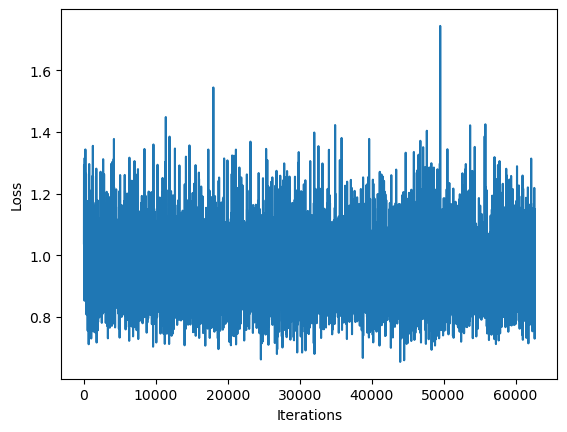

In [7]:
import numpy as np
win = 10

# remove the computational graph from each tensor
losses_values = [x.detach().numpy() for x in losses] 

# rolling window average
losses_values = np.convolve(losses_values, 
                            np.ones(win), 'valid') / win

iters = np.array(range(len(losses_values)))
losses_values = losses_values[::win]
iters = iters[::win] 

plt.figure()
plt.plot(iters, losses_values) 
plt.xlabel('Iterations')
plt.ylabel('Loss');

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=678, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

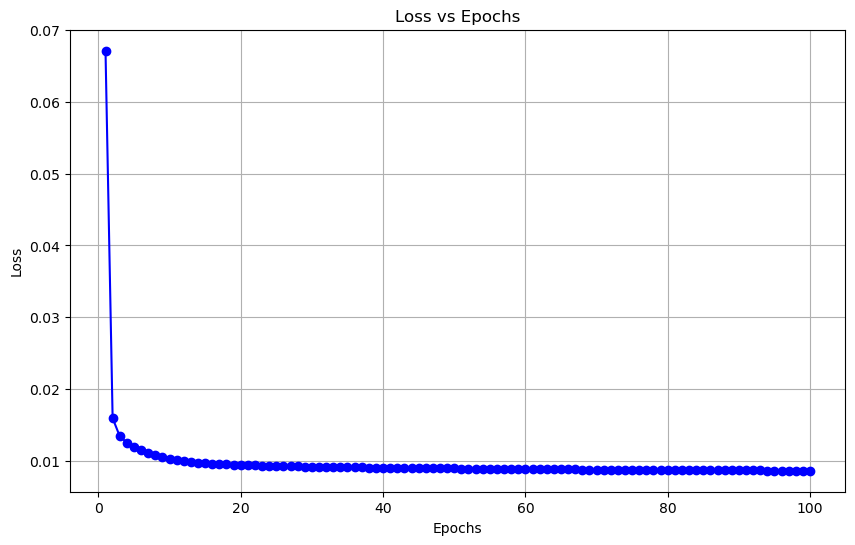

In [26]:
from sklearn.preprocessing import MinMaxScaler
recipes = pd.read_csv('/Users/giovannimaya/Downloads/epi_r-1 (1).csv')

feats = recipes.drop(columns=['cake'])  # Use only the features for autoencoder

# Select numeric columns and fill missing values with medians
numeric_cols = feats.select_dtypes(include=['number']).columns
medians = feats[numeric_cols].median()
feats[numeric_cols] = feats[numeric_cols].fillna(medians)

# Normalize numeric columns using Min-Max Scaling
scaler = MinMaxScaler()
numeric_data_scaled = scaler.fit_transform(feats[numeric_cols])

# Convert DataFrame to torch tensor
tensor_data = torch.tensor(numeric_data_scaled, dtype=torch.float32)

# Define the Autoencoder class with LeakyReLU and Batch Normalization
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),  
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            nn.Linear(128, encoding_dim)
        )
        
    
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3), 
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3), 
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = tensor_data.shape[1]
encoding_dim = 10

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=10)
criterion = nn.MSELoss()
optimizer = optim.AdamW(autoencoder.parameters(), lr=0.0001, weight_decay=1e-5)  

print(autoencoder)

num_epochs = 100  
batch_size = 32  

train_loader = torch.utils.data.DataLoader(tensor_data, batch_size=batch_size, shuffle=True)

losses = []

start_time = time.time()

for epoch in range(num_epochs):
    epoch_loss = 0
    for data in train_loader:
        reconstructed = autoencoder(data)
        loss = criterion(reconstructed, data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time / 60:.2f} minutes.")

# Plotting the loss vs epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()